## Object Detection with Faster R-CNN

Fast R-CNN is a method for object detection that uses region proposal. In this lab, you will use Faster R-CNN pre-trained on the coco dataset. You will learn to detect several objects by name and to use the likelihood of the object prediction being correct.




In [76]:
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/DLguys.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/watts_photos2758112663727581126637_b5d4d192d4_b.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/istockphoto-187786732-612x612.jpeg
! wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/jeff_hinton.png

--2025-12-18 19:51:27--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/DLguys.jpeg
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48572 (47K) [image/jpeg]
Saving to: ‘DLguys.jpeg.2’

DLguys.jpeg.2       100%[===================>]  47.43K  57.9KB/s    in 0.8s    

2025-12-18 19:51:31 (57.9 KB/s) - ‘DLguys.jpeg.2’ saved [48572/48572]

--2025-12-18 19:51:31--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-CV0101EN-Coursera/images%20/images_part_5/watts_photos2758112663727581126637_b5d4d192d4_b.jpeg
Resolving cf-courses-data.s3.us.cloud-o

In [77]:
import torchvision
from torchvision import transforms
import torch
from torch import no_grad

In [78]:
import requests

In [79]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

This function will assign a string name to a predicted class and eliminate predictions whose likelihood is under a thereshold

In [80]:
from typing import List

def get_predictions(
        pred,
        coco_instance_category_names: list,
        threshold: float =.8,
        objects: None | List = None) -> List:
    """
    This function will assign a string name to a predicted class and eliminate predictions whose likelihood  is under a threshold 
    
    pred: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class yhat, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    thre
    """
    zip_list_pred = zip(
        list(
            pred[0]['labels'].numpy()),
            pred[0]['scores'].detach().numpy(),
            list(pred[0]['boxes'].detach().numpy()
            )
    )
    predicted_classes: list = [
        (
            coco_instance_category_names[i], p, [
                (
                    box[0],
                    box[1]
                ),
                (
                    box[2],
                    box[3]
                )
            ]
        ) for i, p, box in zip_list_pred 
    ]

    predicted_classes_stuff: list = [stuff for stuff in predicted_classes if stuff[1] > threshold]

    if objects and predicted_classes_stuff:
        return [
            (name, p, box) for name, p, box in predicted_classes_stuff if name in objects
        ]
    return predicted_classes_stuff


In [192]:
def draw_box(
        predicted_classes,
        image,
        rect_th: int = 10,
        text_size: int  = 3,
        text_th: int = 3) -> None:
    """
    draws box around each object 
    
    predicted_classes: a list where each element contains a tuple that corresponds to information about  the different objects; Each element includes a tuple with the class name, probability of belonging to that class and the coordinates of the bounding box corresponding to the object 
    image : frozen surface 
   
    """

    img = (
        np.clip(
            cv2.cvtColor(
                np.clip(
                    image.numpy().transpose((1, 2, 0)), 0, 1
                ),
                cv2.COLOR_RGB2BGR), 0, 1
            )*255
        ).astype(np.uint8).copy()

    for predicted_class in predicted_classes:

        label = predicted_class[0]
        probability = predicted_class[1]
        box = predicted_class[2]
        t1 = box[0]
        b1, b2 = round(t1[0]), round(t1[1])
        t2 = box[1]
        c1, c2 = round(t2[0]), round(t2[1])
        print(f'{label=}', flush=True)
        print(f'{probability=}', flush=True)
        print(f'{box=}', flush=True)
        print(type(box), flush=True)
        print(box, flush=True)
        print(type(box[0]), box[0], flush=True)
        print(type(box[1]), box[1], flush=True)
        cv2.rectangle(
            img, (b1, b2), (c1, c2), (0, 255, 0), 10
        )
        cv2.putText(
            img,
            label,
            (b1, b2),
            cv2.FONT_HERSHEY_SIMPLEX,
            text_size,
            (0, 255, 0),
            thickness=text_th
        )
        cv2.putText(
            img,
            label+": "+str(round(probability, 2)),
            (b1, b2),
            cv2.FONT_HERSHEY_SIMPLEX,
            text_size,
            (0,255,0),
            thickness=text_th
        )
    plt.figure(figsize=(8, 5))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
    plt.axis("off")
    plt.show()
    del(img)
    del(image)

In [193]:
# def save_RAM(image_=False):
#     global image, img, pred
#     torch.cuda.empty_cache()
#     del(img)
#     del(pred)
#     if image_:
#         image.close()
#         del(image)

# Load Pre-trained Faster R-CNN

Faster R-CNN is a model that predicts both bounding boxes and class scores for potencial objetcs in the image pre-trained on COCO



In [194]:
T1_model = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=True
)
T1_model.eval()


for name, param in T1_model.named_parameters():
    param.requires_grad = False

print('Done')


/home/machine01/.cache/pypoetry/virtualenvs/cognitiveclass-computer-vision-hands-on-wi-KamljRSP-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/machine01/.cache/pypoetry/virtualenvs/cognitiveclass-computer-vision-hands-on-wi-KamljRSP-py3.11/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Done


In [195]:
def model(x):
    with torch.no_grad():
        yhat = T1_model(x)
    return yhat

In [196]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__',
    'person',
    'bicycle',
    'car',
    'motorcycle', 
    'airplane', 
    'bus',
    'train',
    'truck',
    'boat', 
    'traffic light',
    'fire hydrant',
    'N/A',
    'stop sign',
    'parking meter',
    'bench',
    'bird',
    'cat',
    'dog', 
    'horse', 
    'sheep',
    'cow',
    'elephant',
    'bear',
    'zebra',
    'giraffe',
    'N/A', 
    'backpack', 
    'umbrella', 
    'N/A', 
    'N/A',
    'handbag',
    'tie',
    'suitcase', 
    'frisbee', 
    'skis', 
    'snowboard', 
    'sports ball',
    'kite', 
    'baseball bat',
    'baseball glove', 
    'skateboard',
    'surfboard',
    'tennis racket',
    'bottle',
    'N/A',
    'wine glass',
    'cup',
    'fork',
    'knife',
    'spoon',
    'bowl',
    'banana', 
    'apple',
    'sandwich',
    'orange',
    'broccoli', 
    'carrot',
    'hot dog',
    'pizza',
    'donut',
    'cake',
    'chair', 
    'couch',
    'potted plant',
    'bed',
    'N/A',
    'dining table',
    'N/A',
    'N/A',
    'toilet',
    'N/A',
    'tv', 
    'laptop',
    'mouse',
    'remote',
    'keyboard',
    'cell phone',
    'microwave',
    'oven',
    'toaster',
    'sink', 'refrigerator', 'N/A', 'book',
    'clock',
    'vase',
    'scissors',
    'teddy bear', 
    'hair drier',
    'toothbrush'
]
len(COCO_INSTANCE_CATEGORY_NAMES)

91

# Object Localization

In Object Localization we locate the presence of object in an image indicate the locais with a bounding box. Consider the image of Geoffrey Hinto

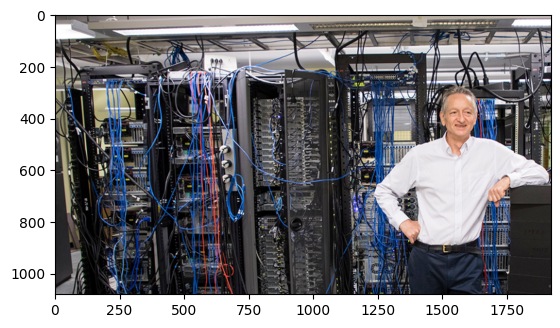

In [197]:
img_path: str = "jeff_hinton.png"
half: float = .5
image = Image.open(img_path)
image.resize(
    [
        int(half * s) for s in image.size
    ]
)

plt.imshow(image)
plt.show()

In [198]:
# We illl create a transform object to convert the image to a tensor

transform = transforms.Compose(
    [transforms.ToTensor()]
)



In [199]:
img = transform(image)
print(type(img))
print(img.shape)

<class 'torch.Tensor'>
torch.Size([3, 1080, 1920])


In [200]:
pred = model([img])
print(type(pred))
print(pred)

<class 'list'>
[{'boxes': tensor([[1223.1688,  301.2499, 1909.1726, 1076.6372],
        [1083.4658,  139.6489, 1413.0601,  355.5671],
        [1737.6132,  356.4109, 1763.9060,  396.9152],
        [ 248.0847,  230.1914,  671.7823, 1033.0297],
        [ 581.8290,  190.3602,  694.4933, 1049.6552],
        [1653.0668,  329.0836, 1700.3866,  481.7519],
        [1433.5494,  272.1133, 1605.0472,  497.6441],
        [1411.8370,  272.9348, 1541.3595,  503.5102],
        [ 106.5353,   81.2254, 1375.0603,  254.9701],
        [1713.5452,  350.7826, 1768.5363,  404.4330],
        [   0.0000,  344.7970,   69.7531, 1064.0659],
        [1627.0776,  328.4587, 1668.2725,  480.6585],
        [ 524.8185,  197.1050,  659.7603,  965.6730],
        [1730.2898,  350.3944, 1777.8383,  534.4158],
        [ 154.6211,  258.5715,  372.4108, 1014.8690],
        [ 617.3351,  151.1407,  737.8684, 1060.4775],
        [1100.5645,   95.3071, 1877.9144,  370.8577],
        [  28.8417,  175.5077,  456.2802,  252.7471],
  

In [201]:
pred[0]['labels']

tensor([ 1, 15, 84,  2, 35, 84, 62,  2,  7, 84, 82, 84, 35, 84,  2, 35, 15, 42,
         2, 82, 62, 84, 62, 84,  7,  2, 84,  7,  2,  9, 84, 84,  2, 84,  2])

In [202]:
pred[0]['scores']

tensor([0.9995, 0.3495, 0.2695, 0.2556, 0.2466, 0.1929, 0.1861, 0.1767, 0.1593,
        0.1528, 0.1484, 0.1392, 0.1295, 0.1290, 0.1249, 0.1208, 0.1094, 0.1026,
        0.1023, 0.1019, 0.0846, 0.0827, 0.0826, 0.0794, 0.0785, 0.0738, 0.0735,
        0.0713, 0.0669, 0.0622, 0.0595, 0.0578, 0.0575, 0.0553, 0.0520])

In [203]:
idx = pred[0]['labels'][0].item()
print(COCO_INSTANCE_CATEGORY_NAMES[idx])


person


In [204]:
# Bounding_box
bbox = pred[0]['boxes'][0].tolist()
bbox

[1223.1688232421875, 301.24993896484375, 1909.172607421875, 1076.63720703125]

In [205]:
t, l, r, b = [round(x) for x in bbox]
t, l, r, b

(1223, 301, 1909, 1077)

We convert the tensor to an open CV array and plot an image with the box:


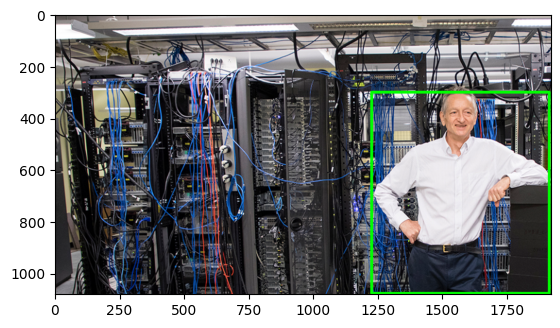

In [206]:
img_plot = (
    np
    .clip(
        cv2
        .cvtColor(
            np
            .clip(
                img
                .numpy()
                .transpose(
                    (1, 2, 0)
                ),0,1),
                cv2.COLOR_RGB2BGR
                ),0,1)*255).astype(np.uint8)

cv2.rectangle(
    img_plot, (t, l), (r, b), (0, 255, 0), 10
)

plt.imshow(cv2.cvtColor(
    img_plot,
    cv2.COLOR_BGR2RGB
))
plt.show()
del img_plot, t, l, r, b

label='person'
probability=0.999546
box=[(1223.1688, 301.24994), (1909.1726, 1076.6372)]
<class 'list'>
[(1223.1688, 301.24994), (1909.1726, 1076.6372)]
<class 'tuple'> (1223.1688, 301.24994)
<class 'tuple'> (1909.1726, 1076.6372)


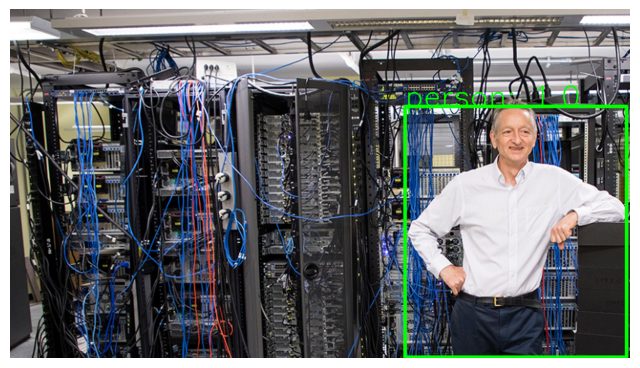

In [207]:
pred_class = get_predictions(
    pred=pred,
    objects="person",
    coco_instance_category_names=COCO_INSTANCE_CATEGORY_NAMES
)
pred_class

draw_box(
    predicted_classes=pred_class, image=img
)
del pred_class


In [208]:
pred_class = get_predictions(
    pred=pred,
    objects="person",
    coco_instance_category_names=COCO_INSTANCE_CATEGORY_NAMES,
    threshold=0.1
)
pred_class

[('person', 0.999546, [(1223.1688, 301.24994), (1909.1726, 1076.6372)])]

In [209]:
pred_class = get_predictions(
    pred=pred,
    objects="person",
    coco_instance_category_names=COCO_INSTANCE_CATEGORY_NAMES,
    threshold=0.3
)
pred_class

[('person', 0.999546, [(1223.1688, 301.24994), (1909.1726, 1076.6372)])]

In [210]:
pred_class = get_predictions(
    pred=pred,
    objects="person",
    coco_instance_category_names=COCO_INSTANCE_CATEGORY_NAMES,
    threshold=0.5
)
pred_class

[('person', 0.999546, [(1223.1688, 301.24994), (1909.1726, 1076.6372)])]

In [211]:
pred_class = get_predictions(
    pred=pred,
    objects="person",
    coco_instance_category_names=COCO_INSTANCE_CATEGORY_NAMES,
    threshold=1
)
pred_class

[]

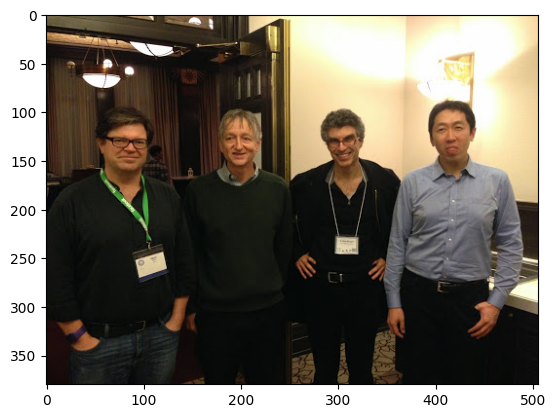

In [212]:
img_path: str = "DLguys.jpeg"
half: float = .5
image = Image.open(img_path)
image.resize(
    [
        int(half * s) for s in image.size
    ]
)

plt.imshow(image)
plt.show()

<class 'torch.Tensor'>
torch.Size([3, 380, 506])
<class 'list'>
[{'boxes': tensor([[346.5518,  83.9248, 495.2577, 373.5154],
        [249.5980,  96.1270, 364.9966, 374.0457],
        [  1.9626,  94.8963, 150.9305, 369.3691],
        [133.7702,  93.7674, 257.4167, 376.5444],
        [101.2039, 133.9207, 128.8474, 175.0922],
        [104.1506, 134.3158, 123.0290, 155.5695],
        [145.4303, 156.6821, 151.3909, 167.1891],
        [471.9007, 265.5569, 505.3035, 305.9233],
        [ 57.4471, 161.3638, 128.9634, 290.6665],
        [ 25.6684, 158.0629,  54.8969, 170.7609],
        [ 50.6617, 159.4646, 116.7572, 239.6380],
        [ 88.2098, 237.1751, 125.5464, 276.8154],
        [ 45.0423, 160.4863, 117.7949, 230.6676],
        [ 85.9762, 206.4755, 128.1621, 275.2021],
        [473.0142, 263.4606, 505.9018, 306.9205],
        [482.2155, 190.2400, 505.8692, 268.7589],
        [128.0793, 165.7544, 154.7116, 172.1455],
        [482.5429, 191.6825, 506.0000, 268.3584],
        [ 28.8213, 169.25

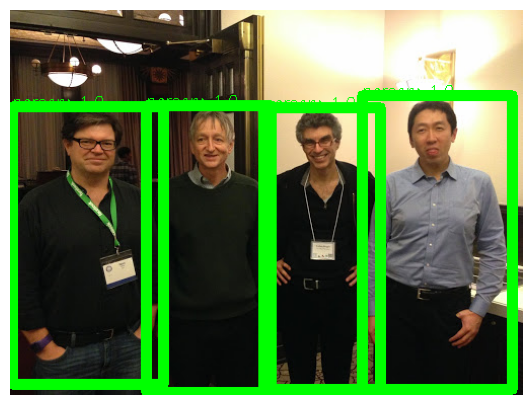

In [213]:
img = transform(image)
print(type(img))
print(img.shape)

pred = model([img])
print(type(pred))
print(pred)

pred_class = get_predictions(
    pred=pred,
    threshold=.8,
    coco_instance_category_names=COCO_INSTANCE_CATEGORY_NAMES
)
pred_class

draw_box(
    predicted_classes=pred_class, image=img, rect_th=1, text_size=.5, text_th=1
)
del pred_class


<class 'torch.Tensor'>
torch.Size([3, 380, 506])
<class 'list'>
[{'boxes': tensor([[346.5518,  83.9248, 495.2577, 373.5154],
        [249.5980,  96.1270, 364.9966, 374.0457],
        [  1.9626,  94.8963, 150.9305, 369.3691],
        [133.7702,  93.7674, 257.4167, 376.5444],
        [101.2039, 133.9207, 128.8474, 175.0922],
        [104.1506, 134.3158, 123.0290, 155.5695],
        [145.4303, 156.6821, 151.3909, 167.1891],
        [471.9007, 265.5569, 505.3035, 305.9233],
        [ 57.4471, 161.3638, 128.9634, 290.6665],
        [ 25.6684, 158.0629,  54.8969, 170.7609],
        [ 50.6617, 159.4646, 116.7572, 239.6380],
        [ 88.2098, 237.1751, 125.5464, 276.8154],
        [ 45.0423, 160.4863, 117.7949, 230.6676],
        [ 85.9762, 206.4755, 128.1621, 275.2021],
        [473.0142, 263.4606, 505.9018, 306.9205],
        [482.2155, 190.2400, 505.8692, 268.7589],
        [128.0793, 165.7544, 154.7116, 172.1455],
        [482.5429, 191.6825, 506.0000, 268.3584],
        [ 28.8213, 169.25

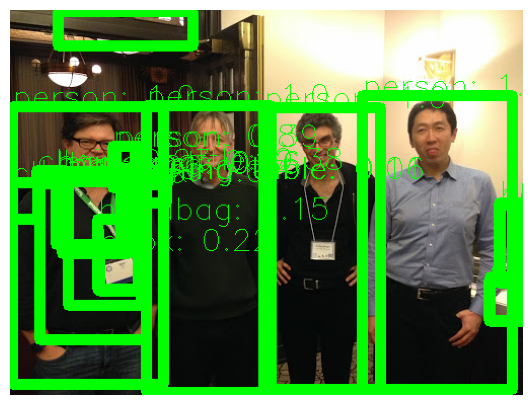

In [214]:
img = transform(image)
print(type(img))
print(img.shape)

pred = model([img])
print(type(pred))
print(pred)

pred_class = get_predictions(
    pred=pred,
    threshold=.01,
    coco_instance_category_names=COCO_INSTANCE_CATEGORY_NAMES
)
pred_class

draw_box(
    predicted_classes=pred_class,
    image=img,
    rect_th=1,
    text_size=1,
     text_th=1
)
del pred_class


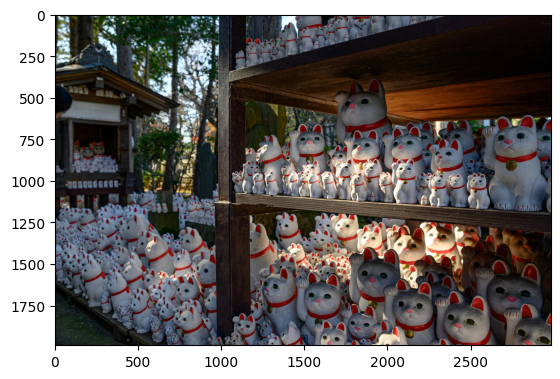

<class 'torch.Tensor'>
torch.Size([3, 1989, 2983])
<class 'list'>
[{'boxes': tensor([[1.9622e+03, 1.6220e+03, 2.2897e+03, 1.9692e+03],
        [2.5780e+03, 6.3741e+02, 2.9561e+03, 1.1811e+03],
        [2.3983e+00, 4.2079e+02, 1.1000e+02, 6.3467e+02],
        [1.0433e+03, 1.7968e+03, 1.2303e+03, 1.9858e+03],
        [1.6711e+03, 1.2084e+03, 1.8353e+03, 1.4420e+03],
        [1.1141e+02, 7.6070e+02, 1.5381e+02, 8.9510e+02],
        [7.3005e+02, 1.7306e+03, 9.4612e+02, 1.9853e+03],
        [1.3150e+03, 1.1961e+03, 1.4921e+03, 1.4110e+03],
        [2.4716e+03, 9.4395e+02, 2.6162e+03, 1.1709e+03],
        [7.3688e+02, 1.2799e+03, 9.2802e+02, 1.5186e+03],
        [1.7873e+03, 1.4306e+03, 2.0929e+03, 1.7933e+03],
        [1.4682e+03, 1.3697e+02, 1.5541e+03, 2.2557e+02],
        [2.0246e+03, 8.7129e+02, 2.1864e+03, 1.1392e+03],
        [2.0018e+03, 1.2671e+03, 2.2074e+03, 1.4817e+03],
        [1.8178e+03, 1.2590e+03, 1.9884e+03, 1.4442e+03],
        [1.5391e+03, 1.2050e+03, 1.6980e+03, 1.4019e+

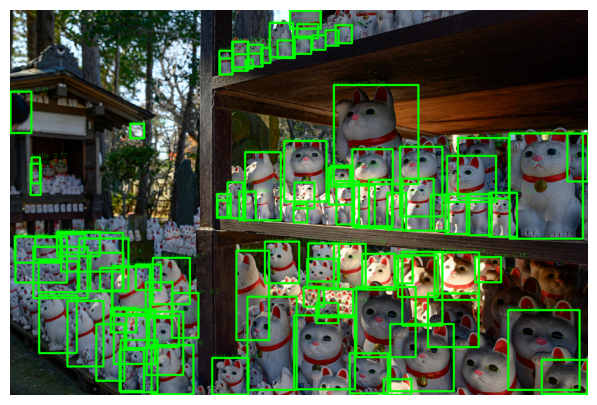

In [215]:
img_path='pexels-macrolingo-llc-2158142977-35202826.jpg'
image = Image.open(img_path)
image.resize([int(half * s) for s in image.size])
plt.imshow(np.array(image))
plt.show()

img = transform(image)
print(type(img))
print(img.shape)

pred = model([img])
print(type(pred))
print(pred)

pred_class = get_predictions(
    pred=pred,
    threshold=.01,
    coco_instance_category_names=COCO_INSTANCE_CATEGORY_NAMES
)
pred_class

draw_box(
    predicted_classes=pred_class,
    image=img,
    rect_th=1,
    text_size=1,
     text_th=1
)
del pred_class


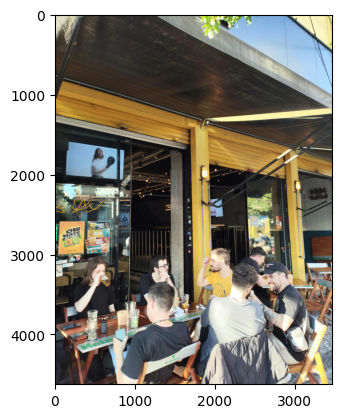

<class 'torch.Tensor'>
torch.Size([3, 4624, 3472])
<class 'list'>
[{'boxes': tensor([[1.9355e+02, 3.0427e+03, 8.3798e+02, 3.8162e+03],
        [1.7378e+03, 3.0786e+03, 3.0077e+03, 4.5894e+03],
        [1.7642e+03, 2.9083e+03, 2.2356e+03, 3.6711e+03],
        [6.7587e+02, 3.3573e+03, 1.7369e+03, 4.6240e+03],
        [1.0340e+03, 3.0077e+03, 1.5348e+03, 3.6183e+03],
        [2.4813e+03, 3.0714e+03, 3.1686e+03, 4.4092e+03],
        [1.0276e+03, 3.9999e+03, 1.8174e+03, 4.6240e+03],
        [3.1126e+03, 3.2472e+03, 3.4696e+03, 3.8943e+03],
        [4.4321e+02, 1.6697e+03, 6.9725e+02, 2.0436e+03],
        [7.7557e+02, 3.7038e+03, 9.0245e+02, 3.9114e+03],
        [2.7971e+03, 3.7877e+03, 3.3930e+03, 4.6126e+03],
        [3.9408e+02, 3.7270e+03, 5.3977e+02, 4.0707e+03],
        [2.5175e+03, 2.6979e+03, 2.7101e+03, 2.9925e+03],
        [1.5911e+03, 3.5046e+03, 1.6761e+03, 3.6991e+03],
        [5.5840e+01, 3.6517e+03, 1.3230e+03, 4.5667e+03],
        [1.2281e+02, 3.6477e+03, 2.8809e+02, 3.8482e+

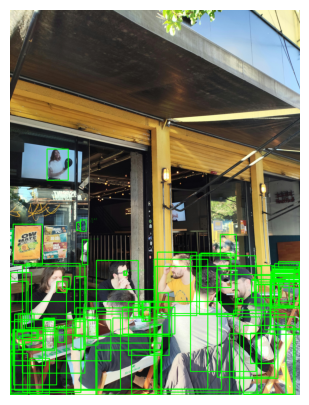

In [216]:
img_path='pexels-eddi-len-do-35083597.jpg'
image = Image.open(img_path)
image.resize([int(half * s) for s in image.size])
plt.imshow(np.array(image))
plt.show()

img = transform(image)
print(type(img))
print(img.shape)

pred = model([img])
print(type(pred))
print(pred)

pred_class = get_predictions(
    pred=pred,
    threshold=.01,
    coco_instance_category_names=COCO_INSTANCE_CATEGORY_NAMES
)
pred_class

draw_box(
    predicted_classes=pred_class,
    image=img,
    rect_th=1,
    text_size=1,
     text_th=1
)
del pred_class


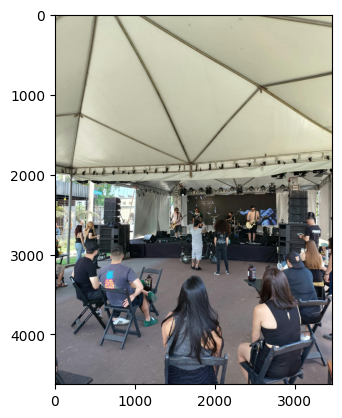

<class 'torch.Tensor'>
torch.Size([3, 4624, 3472])


In [ ]:
img_path='pexels-eddi-len-do-35120241.jpg'
image = Image.open(img_path)
image.resize([int(half * s) for s in image.size])
plt.imshow(np.array(image))
plt.show()

img = transform(image)
print(type(img))
print(img.shape)

pred = model([img])
print(type(pred))
print(pred)

pred_class = get_predictions(
    pred=pred,
    threshold=.01,
    coco_instance_category_names=COCO_INSTANCE_CATEGORY_NAMES
)
pred_class

draw_box(
    predicted_classes=pred_class,
    image=img,
    rect_th=1,
    text_size=1,
     text_th=1
)
del pred_class


<class 'torch.Tensor'>
torch.Size([3, 4624, 3472])
<class 'list'>
------------------------------
Get
[('person', 0.9959974, [(1964.5951, 2559.7095), (2205.085, 3267.6318)]), ('person', 0.9955485, [(1318.8984, 3269.9272), (2127.9917, 4590.576)]), ('person', 0.9874599, [(1681.7561, 2467.898), (1863.0614, 3223.1648)]), ('person', 0.98325306, [(1452.1816, 2411.9915), (1592.8129, 2795.0986)]), ('person', 0.9781473, [(2326.8105, 3155.8809), (3194.3577, 4571.834)]), ('person', 0.97412485, [(530.8786, 2911.961), (1256.0918, 3952.6624)]), ('person', 0.9696922, [(219.79182, 2852.6157), (628.5265, 3781.2385)]), ('person', 0.96697414, [(239.38777, 2553.8086), (381.61755, 3120.416)]), ('person', 0.9641925, [(2829.132, 2959.9526), (3297.7131, 3608.0078)]), ('person', 0.9565747, [(2380.286, 2396.8267), (2559.9568, 2868.6855)]), ('person', 0.9133662, [(359.26654, 2607.4048), (545.1654, 2966.493)]), ('person', 0.88327134, [(3041.6514, 2524.6445), (3361.2349, 3311.7986)]), ('person', 0.8709365, [(3.5583

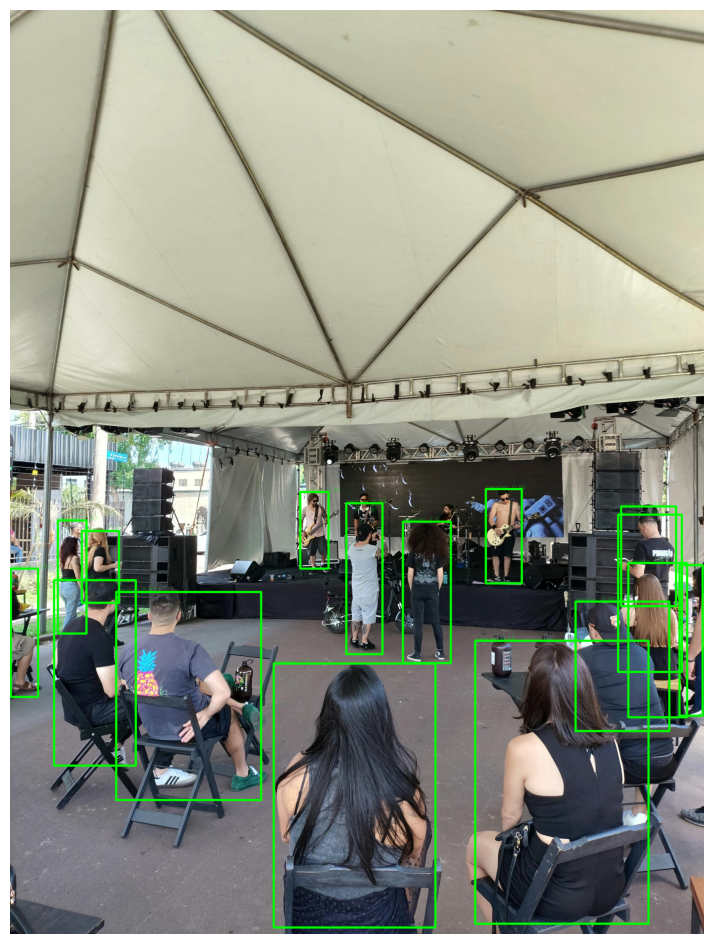

In [ ]:
img_path='pexels-eddi-len-do-35120241.jpg'
image = Image.open(img_path)
image.resize([int(half * s) for s in image.size])
# plt.imshow(np.array(image))
# plt.show()

img = transform(image)
print(type(img))
print(img.shape)

pred = model([img])
print(type(pred))
# print(pred)

pred_class = get_predictions(
    pred=pred,
    threshold=.8,
    objects=['person'],
    coco_instance_category_names=COCO_INSTANCE_CATEGORY_NAMES
)

print('-'*30)
print('Get')
print(pred_class)
print(f'Total peoples {len(pred_class)}')
print('-'*30)

draw_box(
    predicted_classes=pred_class,
    image=img,
    rect_th=1,
    text_size=1,
     text_th=1
)
del pred_class
